# Collect music bands, celebrities from web
We attempt to quantify cultural affinity with media consumption, via musical taste.

- Collect American and Latin American artists from Wikipedia.
- Align artists to usernames in Twitter (most popular search results).
- Determine coverage.

# Table of contents
1. Collect data
   1. [Musicians from Wikipedia](#Collect-list-of-musicians)
   2. [Musician Twitter handles](#Collect-musician-Twitter-handles)
   3. [@-mentions of musicians on Twitter](#Estimate-coverage-in-Twitter-data)
   4. [@-mentions of musicians on Twitter (full Wiki lists)](#Test-coverage-of-full-pop-musician-lists)
2. Analyze data
   1. [Compute musical sharing percents](#Check-cultural-affinity-among-musician-sharers)
   2. [Find local Twitter users](#Find-Twitter-locals)
   3. [Compare musical sharing percents](#Compare-musician-sharing-rates-among-locals)
   4. [Find local Twitter users (with approximate unambiguous locations)](##Geolocate-authors-who-mention-musicians)
   5. [Compare musical sharing percents](#Compare-musician-sharing-rates-among-geolocated-locals)

In [185]:
import wikipedia
from urllib import request
import pandas as pd

### Collect list of musicians

In [123]:
wiki_base_url = 'https://en.wikipedia.org/wiki/'
# latin_musician_category = 'Category:Latin_pop_singers'
us_musician_category = 'Category:American_female_pop_singers'
url_i = f'{wiki_base_url}{us_musician_category}'
print(url_i)
res_i = request.urlopen(url_i).read().decode('utf-8')
print(res_i)
## no content available for category pages ;_;
# latin_musician_page = wikipedia.WikipediaPage(latin_musician_category)
# print(latin_musician_page)

https://en.wikipedia.org/wiki/Category:American_female_pop_singers
<!DOCTYPE html>
<html class="client-nojs" lang="en" dir="ltr">
<head>
<meta charset="UTF-8"/>
<title>Category:American female pop singers - Wikipedia</title>
<script>document.documentElement.className="client-js";RLCONF={"wgBreakFrames":!1,"wgSeparatorTransformTable":["",""],"wgDigitTransformTable":["",""],"wgDefaultDateFormat":"dmy","wgMonthNames":["","January","February","March","April","May","June","July","August","September","October","November","December"],"wgMonthNamesShort":["","Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"],"wgRequestId":"Xh@TxApAME4AAA@b8FkAAABH","wgCSPNonce":!1,"wgCanonicalNamespace":"Category","wgCanonicalSpecialPageName":!1,"wgNamespaceNumber":14,"wgPageName":"Category:American_female_pop_singers","wgTitle":"American female pop singers","wgCurRevisionId":903403756,"wgRevisionId":903403756,"wgArticleId":25588696,"wgIsArticle":!0,"wgIsRedirect":!1,"wgAction":"view","wg

In [208]:
from bs4 import BeautifulSoup
from functools import reduce
import re
# filter bad stuff
def filter_category_members(div):
    div_list_children = div.find('ul').find_all('li')
    test_child = list(div_list_children[0].children)
    contains_category_members = test_child[0].name == 'a'
    return contains_category_members
# extract category members
MAX_TITLE_LEN = 30 # filter false positives like 'Lo Nuestro Award for Pop New Artist of the Year'
PAREN_MATCHER = re.compile(' \(.+\)$')
def extract_category_members(div):
    """
    Extract URL and name.
    """
    category_members = div.find_all('a')
    category_member_urls = list(map(lambda x: x['href'], category_members))
    category_member_names = list(map(lambda x: x['title'], category_members))
    # remove parens
    category_member_names = list(map(lambda x: PAREN_MATCHER.sub('', x), category_member_names))
    # combine
    category_member_info = list(zip(category_member_names, category_member_urls))
    # remove long names
    category_member_info = list(filter(lambda x: len(x[1]) <= MAX_TITLE_LEN, category_member_info))
    return category_member_info

musician_page_categories = ['Category:Latin_pop_singers', 'Category:American_female_pop_singers', 
                            'Category:American_male_pop_singers']
full_wiki_base_url = 'https://en.wikipedia.org/wiki/'
mini_wiki_base_url = 'https://en.wikipedia.org/'
category_members_per_page = []
for page_category in musician_page_categories:
    print('page=%s'%(page_category))
    category_members_combined = []
    has_next_page = True
    url_i = f'{full_wiki_base_url}{page_category}'
    while(has_next_page):
        res_i = request.urlopen(url_i).read().decode('utf-8')
        soup_i = BeautifulSoup(res_i)
        div_class = 'mw-category-group'
        divs = soup_i.find_all(class_=div_class)
        ## collect category members
        divs_clean = list(filter(lambda x: filter_category_members(x), divs))
        category_members = list(reduce(lambda x,y: x+y, map(lambda x: extract_category_members(x), divs_clean)))
        category_members_combined += category_members
        ## check for next page
        next_page_ref = soup_i.find('a', text='next page')
        has_next_page = next_page_ref is not None and 'href' in next_page_ref
        if(has_next_page):
            next_page_url = next_page_ref['href']
            url_i = f'{mini_wiki_base_url}{next_page_url}'
    category_members_per_page.append(category_members_combined)
category_members_data = list(map(lambda x: pd.DataFrame(x, columns=['name', 'wiki_url']), category_members_per_page))
category_members_data = pd.concat(list(map(lambda x: x[0].assign(**{'category' : x[1].split(':')[-1]}), zip(category_members_data, musician_page_categories))), axis=0)

page=Category:Latin_pop_singers
page=Category:American_female_pop_singers
page=Category:American_male_pop_singers


In [221]:
display(category_members_data.head())
print(category_members_data.loc[:, 'category'].value_counts())
# print(category_members_data.drop_duplicates(['name', 'category'], inplace=False).loc[:, 'category'].value_counts())

,name,wiki_url,category
0,Christina Aguilera,/wiki/Christina_Aguilera,Latin_pop_singers
1,Paulina Aguirre,/wiki/Paulina_Aguirre,Latin_pop_singers
2,Anahí,/wiki/Anah%C3%AD,Latin_pop_singers
3,Anitta,/wiki/Anitta_(singer),Latin_pop_singers
4,Marc Anthony,/wiki/Marc_Anthony,Latin_pop_singers


American_female_pop_singers    199
American_male_pop_singers      122
Latin_pop_singers              102
Name: category, dtype: int64


## Collect musician Twitter handles

Now that we have a decent sized list, let's try to find these musicians on Twitter.

We will assume that the most popular search result is the best candidate for the musician's Twitter handle.

In [210]:
import twitter
auth_data_file = '../../data/mined_tweets/twitter_auth.csv'
auth_data = dict([l.strip().split(',') for l in open(auth_data_file, 'r')])
api = twitter.Api(consumer_key=auth_data['consumer_key'], consumer_secret=auth_data['consumer_secret'],
                  access_token_key=auth_data['access_token'], access_token_secret=auth_data['access_secret'])

In [225]:
from time import sleep
music_search_results = []
RATE_LIMIT_SLEEP_TIME=180
for member_name in category_members_data.loc[:, 'name'].values:
    search_success = False
    while(not search_success):
        try:
            search_results = api.GetUsersSearch(term=member_name)
            search_success = True
        except Exception as e:
            print('error %s'%(e))
            print('hit limit; sleeping for %d sec'%(RATE_LIMIT_SLEEP_TIME))
            sleep(RATE_LIMIT_SLEEP_TIME)
    # sort by followers: update => NOT GOOD for rarer artists like Paulina Aguirre (search returns governor of province in Chile)
#     search_results = list(sorted(search_results, key=lambda x: x.followers_count, reverse=True))
    if(len(search_results) > 0):
        most_likely_match = search_results[0]
        music_search_results.append([member_name, most_likely_match.screen_name, most_likely_match.followers_count])
    else:
        print('name %s had 0 results'%(member_name))
music_search_results = pd.DataFrame(music_search_results, columns=['name', 'screen_name', 'followers_count'])
# drop duplicates
music_search_results.drop_duplicates('name', inplace=True)

Let's check a random selection of 10 from each category to test precision.

In [230]:
import numpy as np
np.random.seed(123)
musician_twitter_data = pd.merge(category_members_data, music_search_results, on='name')
sample_size = 10
for category_i, data_i in musician_twitter_data.groupby('category'):
    print('testing category=%s'%(category_i))
    data_i = data_i.loc[np.random.choice(data_i.index, sample_size, replace=False), :]
    display(data_i.loc[:, ['name', 'screen_name']].head(sample_size))

testing category=American_female_pop_singers


,name,screen_name
180,Jo Ann Campbell,Northwest_DC
129,Madilyn Bailey,rockstarbonstar
144,Alycia Bellamy,AlyciaBell80599
107,Paula Abdul,PaulaAbdul
263,Zooey Deschanel,ZooeyDeschanel
243,Tiffany Darwish,tiffanytunes
193,Tia Carrere,TiaCarrere
166,Taylor Bright,taylorbright
156,Crystal Bowersox,crystalbowersox
217,Rosemary Clooney,RClooneys


testing category=American_male_pop_singers


,name,screen_name
363,Ben E. King,ben_e_king
345,CeeLo Green,CeeLoGreen
373,Johnny Mathis,MathisJohnny
293,Michael Alig,Alig_Aligula
385,Giovanni Niubo,giovanniniubo
318,Phil Campos,CamPhilSci
302,Bazzi,bazzi
375,Adam Met,AdamAJRbrothers
303,Ryan Beatty,TheRyanBeatty
402,Sam Tsui,SamuelTsui


testing category=Latin_pop_singers


,name,screen_name
5,Marc Anthony,MarcAnthony
38,Raúl Fuentes Cuenca,Raulcantante
37,Frankie J,therealfrankieJ
92,Raquel Sofía,raquelsofia
45,JC Gonzalez,JCGonzalezMusic
88,Paulina Rubio,PaulinaRubio
36,Francinne,SuyanneRosa
49,Julio Iglesias,JulioIglesias
82,Violeta Rivas,violetarivas
57,Celia Mara,Celia1963


- American female pop = 5/10
- American male pop = 8/10
- Latin pop = 7/10

Not great! We should probably restrict ourselves to verified accounts to cut down on the noise.

In [233]:
from time import sleep
verified_music_search_results = []
RATE_LIMIT_SLEEP_TIME=180
for member_name in category_members_data.loc[:, 'name'].values:
    search_success = False
    while(not search_success):
        try:
            search_results = api.GetUsersSearch(term=member_name)
            search_success = True
        except Exception as e:
            print('error %s'%(e))
            print('hit limit; sleeping for %d sec'%(RATE_LIMIT_SLEEP_TIME))
            sleep(RATE_LIMIT_SLEEP_TIME)
#     search_results = list(sorted(search_results, key=lambda x: x.followers_count, reverse=True))
    # only keep verified accounts
    search_results = list(filter(lambda x: x.verified, search_results))
    if(len(search_results) > 0):
        most_likely_match = search_results[0]
        verified_music_search_results.append([member_name, most_likely_match.screen_name, most_likely_match.followers_count])
    else:
        print('name %s had 0 results'%(member_name))
verified_music_search_results = pd.DataFrame(verified_music_search_results, columns=['name', 'screen_name', 'followers_count'])
# drop duplicates (ex. Christina Aguilera in both American and Latin pop)
verified_music_search_results.drop_duplicates('name', inplace=True)

name Linda Bandry had 0 results
name Moisés Canelo had 0 results
name Cáthia had 0 results
name D'manti had 0 results
name Guillermo Dávila had 0 results
name Erika Ender had 0 results
name Francinne had 0 results
name Raúl Fuentes Cuenca had 0 results
name Eric Fukusaki had 0 results
name Odalys García had 0 results
name Magos Herrera had 0 results
name Janid had 0 results
name Selena Lee Canales had 0 results
name Celia Mara had 0 results
name Lisette Melendez had 0 results
name Mike Bahía had 0 results
name MioSoty had 0 results
name Alejandro Montaner had 0 results
name Javier Monthiel had 0 results
name Fernando Osorio had 0 results
name Pijuán had 0 results
name Luz Rios had 0 results
name Violeta Rivas had 0 results
name Danny Rivera had 0 results
name Élan Luz Rivera had 0 results
name Lourdes Robles had 0 results
name Miriam Sandler had 0 results
name Tahis had 0 results
name Victoria Acosta had 0 results
name Sharon Aguilar had 0 results
name Josie Aiello had 0 results
name S

In [234]:
import numpy as np
np.random.seed(123)
verified_musician_twitter_data = pd.merge(category_members_data, verified_music_search_results, on='name')
print(verified_musician_twitter_data.loc[:, 'category'].value_counts())
sample_size = 10
for category_i, data_i in verified_musician_twitter_data.groupby('category'):
    print('testing category=%s'%(category_i))
    data_i = data_i.loc[np.random.choice(data_i.index, sample_size, replace=False), :]
    display(data_i.loc[:, ['name', 'screen_name']].head(sample_size))

American_female_pop_singers    102
American_male_pop_singers       83
Latin_pop_singers               74
Name: category, dtype: int64
testing category=American_female_pop_singers


,name,screen_name
83,Alyson,alydenisof
146,Julee Cruise,clairehly
164,Zooey Deschanel,ZooeyDeschanel
103,Lola Blanc,ohlalola
138,Sabrina Claudio,thisisBURNS
1,Christina Aguilera,xtina
80,Akino,ChopReid
125,Vikki Carr,VikkiCarrOffcl
157,Luann de Lesseps,CountessLuann
79,Ailee,itzailee


testing category=American_male_pop_singers


,name,screen_name
252,Justin Timberlake,jtimberlake
234,Adam Met,AdamAJRbrothers
257,Maurice White,MauriceWhiteEWF
180,Andy,Andy
219,JMSN,iamjmsn
215,Hulk Hogan,HulkHogan
192,Tae Brooks,TaeBrooks
258,Kevin Woo,kevinwoo91
213,Jack Griffo,JackGriffo
233,AJ McLean,aj_mclean


testing category=Latin_pop_singers


,name,screen_name
43,Ricky Martin,RickyMartin247
20,David DeMaría,DavidDeMaria
47,Yolandita Monge,yolanditamonge
55,Laura Pausini,LauraPausini
40,Lucero,luceromusic
46,Luis Miguel,LMXLM
33,Gisselle,lapdgespinoza
15,Cristian Castro,CristianCastro
0,Christina Aguilera,xtina
65,Marco Antonio Solís,MarcoASolis


- American female pop = 0 0 1 1 0 1 0 1 1 1 = 6/10
- American male pop = 1 1 1 0 1 1 1 1 1 1 = 9/10
- Latin pop = 0 1 1 1 1 1 0 1 1 1 = 8/10

Better! Let's (1) sort by follower count and (2) match the Wikipedia name with the Twitter name to increase precision.

In [240]:
from unidecode import unidecode
from time import sleep
matched_verified_music_search_results = []
RATE_LIMIT_SLEEP_TIME=180
for member_name in category_members_data.loc[:, 'name'].values:
    clean_member_name = unidecode(member_name)
    search_success = False
    while(not search_success):
        try:
            search_results = api.GetUsersSearch(term=member_name)
            search_success = True
        except Exception as e:
            print('error %s'%(e))
            print('hit limit; sleeping for %d sec'%(RATE_LIMIT_SLEEP_TIME))
            sleep(RATE_LIMIT_SLEEP_TIME)
    # only keep verified accounts
    search_results = list(filter(lambda x: x.verified, search_results))
    # only keep name matches
    search_results = list(filter(lambda x: unidecode(x.name) == clean_member_name, search_results))
    # sort by followers
    search_results = list(sorted(search_results, key=lambda x: x.followers_count, reverse=True))
    if(len(search_results) > 0):
        most_likely_match = search_results[0]
        matched_verified_music_search_results.append([member_name, most_likely_match.screen_name, most_likely_match.followers_count])
    else:
        print('name %s had 0 results'%(member_name))
matched_verified_music_search_results = pd.DataFrame(matched_verified_music_search_results, columns=['name', 'screen_name', 'followers_count'])
# drop duplicates (ex. Christina Aguilera in both American and Latin pop)
matched_verified_music_search_results.drop_duplicates('name', inplace=True)

name Linda Bandry had 0 results
name Lou Bega had 0 results
name Ari Borovoy had 0 results
name Moisés Canelo had 0 results
name Cáthia had 0 results
name Chayanne had 0 results
name D'manti had 0 results
name Guillermo Dávila had 0 results
name Erika Ender had 0 results
name Francinne had 0 results
name Raúl Fuentes Cuenca had 0 results
name Eric Fukusaki had 0 results
name GALE had 0 results
name Odalys García had 0 results
name Gisselle had 0 results
name Magos Herrera had 0 results
name Julio Iglesias had 0 results
name Janid had 0 results
name Selena Lee Canales had 0 results
name Fanny Lú had 0 results
name Maía had 0 results
name Celia Mara had 0 results
name Lisette Melendez had 0 results
name Mike Bahía had 0 results
name MioSoty had 0 results
name Alejandro Montaner had 0 results
name Javier Monthiel had 0 results
name Marco Moré had 0 results
name Danny Ocean had 0 results
name Fernando Osorio had 0 results
name Yolanda Pérez had 0 results
name Pijuán had 0 results
name Abra

In [244]:
matched_verified_musician_twitter_data = pd.merge(category_members_data, matched_verified_music_search_results, on='name')
print(matched_verified_musician_twitter_data.loc[:, 'category'].value_counts())
# get recall: twitter / wiki names
print(matched_verified_musician_twitter_data.loc[:, 'category'].value_counts() / category_members_data.drop_duplicates('name', inplace=False).loc[:, 'category'].value_counts())

American_female_pop_singers    64
American_male_pop_singers      60
Latin_pop_singers              59
Name: category, dtype: int64
American_female_pop_singers    0.326531
American_male_pop_singers      0.495868
Latin_pop_singers              0.578431
Name: category, dtype: float64


Surprisingly, better coverage for Latin American musicians than for US musicians, maybe because Wikipedia covers long tail of lesser-known US musicians.

In [242]:
np.random.seed(123)
sample_size = 10
for category_i, data_i in matched_verified_musician_twitter_data.groupby('category'):
    print('testing category=%s'%(category_i))
    data_i = data_i.loc[np.random.choice(data_i.index, sample_size, replace=False), :]
    display(data_i.loc[:, ['name', 'screen_name']].head(sample_size))

testing category=American_female_pop_singers


,name,screen_name
110,Sheryl Crow,SherylCrow
90,Camryn,camrynrocks
122,Joy Enriquez,JoyEnriquez
112,Andra Day,AndraDayMusic
82,Michelle Branch,michellebranch
99,Michelle Chamuel,MichelleChamuel
103,Ciara,ciara
102,Cher,cher
86,Kaci Brown,KaciBrown
74,Madison Beer,madisonbeer


testing category=American_male_pop_singers


,name,screen_name
127,Paul Anka,paulanka
125,AM,AstonMerrygold
130,Ryan Beatty,TheRyanBeatty
159,Austin Mahone,AustinMahone
177,Justin Timberlake,jtimberlake
139,Nick Carter,nickcarter
174,Rex Smith,rexwsmith
170,Tony Orlando,TonyOrlando
147,CeeLo Green,CeeLoGreen
155,Khalid,thegreatkhalid


testing category=Latin_pop_singers


,name,screen_name
0,Christina Aguilera,xtina
5,Marc Anthony,MarcAnthony
24,Fonseca,Fonseca
17,David DeMaría,DavidDeMaria
12,Manuel Carrasco,manuelcarrasco_
21,José Feliciano,josefeliciano
43,Noelia,soynoeliafranco
19,Gloria Estefan,GloriaEstefan
28,Kany García,kanygarcia
23,Fey,officialfey


- American female pop = 1 1 1 1 1 1 1 1 1 1 = 10/10
- American male pop = 1 1 1 1 1 1 0 1 1 1 = 9/10
- Latin pop = 1 1 1 1 1 1 1 1 1 1 = 10/10

High precision, probably lower recall. Let's use this for now.

In [310]:
# save for later
matched_verified_musician_twitter_data.to_csv('../../data/mined_tweets/matched_verified_american+latinamerican_musicians_twitter_screennames.tsv', sep='\t', index=False)

### Estimate coverage in Twitter data
Now that we have a list of musicians and their screennames, we can look for coverage of Twitter data.

First, build ES queries with names in chunks.

In [318]:
from math import ceil
from data_helpers import collect_scroll_results
# find all posts by user
# chunks
MAX_CHUNK_SIZE = 50
musician_screen_names_combined = matched_verified_musician_twitter_data.loc[:, 'screen_name'].values
name_chunk_count = int(ceil(len(musician_screen_names_combined) / MAX_CHUNK_SIZE))
name_chunks = [musician_screen_names_combined[(i*MAX_CHUNK_SIZE):((i+1)*MAX_CHUNK_SIZE)] for i in range(name_chunk_count)]
es_queries = []
for name_chunk in name_chunks:
    name_str = '|'.join(list(map(lambda x: f'@{x}'.lower(), name_chunk)))
    es_query = {
        'query' : {
            'match' : {
                'text' : name_str
            }
        }
    }
    es_queries.append(es_query)

In [325]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import execute_queries_all_instances
# print(es_queries)
es_query_results = []
es_cluster_name = 'twitter_posts'
es_year_month_pairs = [(2018, 7, 9), (2018, 10, 12), (2019, 1, 3), (2019, 4, 6)]
es_base_dir = '/hg190/elastic_search/'
    # one instance at a time
#     es_query_result_i = collect_scroll_results(es, es_instance_name, es_query_i, MAX_SCROLL_SIZE=1000)
    # multiple instances
es_query_result = execute_queries_all_instances(es_queries, es_year_month_pairs=es_year_month_pairs,
                                                es_cluster_name=es_cluster_name,
                                                es_base_dir=es_base_dir)
# collapse
es_query_result = list(reduce(lambda x,y: x+y, es_query_result))

## old code: individual query
# es_query = {
#     'query' : {
#         'match' : {
#             'text' : '@xtina'
#         }
#     }
# }
# aggregate counts for user => cannot use because memory problems
# es_query = {
#     "query" : {
#         "filtered": {
#           "filter": { "term": {"user_screen_name":'barackobama'} }
#         }
#     },
#         'aggs' : {
#             'screen_name' : {
#                 'terms' : {
#                     'field' : 'user_screen_name',
# #                     'size' : 0,
#                 }
#             }
#         },
#     }
# es_res = es.search(index=es_instance_name, body=es_query, scroll='2m')

# scroll results
# es_res = collect_scroll_results(es, es_instance_name, es_query, MAX_SCROLL_SIZE=1000)

starting index twitter_posts_2018_m_7_9
sleeping for 150 sec to wait for ES to initialize
starting index twitter_posts_2018_m_10_12
sleeping for 150 sec to wait for ES to initialize
starting index twitter_posts_2019_m_1_3
sleeping for 150 sec to wait for ES to initialize
starting index twitter_posts_2019_m_4_6
sleeping for 150 sec to wait for ES to initialize


Let's restrict to just RTs and just tweets written in EN/ES.

In [337]:
import re
# filter
RT_matcher = re.compile('^RT @')
# filtered_res = list(filter(lambda x: RT_matcher.search(x['_source']['text']) is not None, es_query_results))
filtered_res = list(filter(lambda x: RT_matcher.search(x['text']) is not None, es_query_result))
# limit to EN/ES
langs = ['en', 'es']
lang_score_thresh = 75
filtered_res = list(filter(lambda x: x['lang'] in langs and x['lang_score'] >= lang_score_thresh, filtered_res))
print(len(filtered_res))

249516


OK! Who are the most frequently retweeted musicians?

In [338]:
RT_name_matcher = re.compile('(?<=^RT @)([a-zA-Z_0-9]+)')
RT_names = list(map(lambda x: RT_name_matcher.search(x['text']).group(0), filtered_res))
RT_name_count = pd.Series(RT_names).value_counts()
display(RT_name_count.head(10))
# RT_name_matcher.search('RT @xtina: blah').group(0)

thegreatkhalid    18373
BTS_twt           12780
LanaDelRey        12479
AlejandroSanz      7596
MariahCarey        7269
cher               6517
chrisbrown         5506
madisonbeer        3896
ciara              3850
shakira            3550
dtype: int64

No surprise: most of the shares are for US American artists, and also BTS for some reason.

Let's see what the distribution is like across the different music categories.

In [339]:
matched_verified_musician_twitter_data.head()

,name,wiki_url,category,screen_name,followers_count
0,Christina Aguilera,/wiki/Christina_Aguilera,Latin_pop_singers,xtina,17027544
1,Christina Aguilera,/wiki/Christina_Aguilera,American_female_pop_singers,xtina,17027544
2,Paulina Aguirre,/wiki/Paulina_Aguirre,Latin_pop_singers,paulinaaguirre7,5553
3,Anahí,/wiki/Anah%C3%AD,Latin_pop_singers,Anahi,9846446
4,Anitta,/wiki/Anitta_(singer),Latin_pop_singers,Anitta,9888402


In [344]:
RT_name_count_df = pd.DataFrame(RT_name_count, columns=['RT_count']).reset_index().rename(columns={'index':'screen_name'})
RT_category_counts = pd.merge(RT_name_count_df, matched_verified_musician_twitter_data.loc[:, ['category', 'screen_name', 'followers_count']], on='screen_name')
display(RT_category_counts.groupby('category').apply(lambda x: x.loc[:, 'RT_count'].sum()))
display(RT_category_counts.groupby('category').apply(lambda x: x.loc[:, 'RT_count'].mean()))

category
American_female_pop_singers    42628
American_male_pop_singers      39066
Latin_pop_singers              28620
dtype: int64

category
American_female_pop_singers    819.769231
American_male_pop_singers      751.269231
Latin_pop_singers              561.176471
dtype: float64

Even though we have fewer total US American musicians, we still see more RTs per musician in the American categories. Not surprising, since there are more English speakers on Twitter.

Who are the most-RTed musicians in each category?

In [346]:
for category_i, data_i in RT_category_counts.groupby('category'):
    print('category=%s'%(category_i))
    data_i.sort_values('RT_count', inplace=True, ascending=False)
    display(data_i.head(5))

category=American_female_pop_singers


/hg190/istewart6/miniconda3/envs/loanword_adoption/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,screen_name,RT_count,category,followers_count
1,LanaDelRey,12479,American_female_pop_singers,9701362
3,MariahCarey,7269,American_female_pop_singers,21480857
4,cher,6517,American_female_pop_singers,3771787
6,madisonbeer,3896,American_female_pop_singers,2542611
7,ciara,3850,American_female_pop_singers,11297814


category=American_male_pop_singers


,screen_name,RT_count,category,followers_count
0,thegreatkhalid,18373,American_male_pop_singers,4270123
5,chrisbrown,5506,American_male_pop_singers,31583147
11,AustinMahone,2297,American_male_pop_singers,9613500
14,HulkHogan,1828,American_male_pop_singers,2260765
15,michaeljackson,1803,American_male_pop_singers,2227025


category=Latin_pop_singers


,screen_name,RT_count,category,followers_count
2,AlejandroSanz,7596,Latin_pop_singers,19649081
8,shakira,3550,Latin_pop_singers,51727025
9,xtina,2611,Latin_pop_singers,17027544
12,LuceroMexico,2202,Latin_pop_singers,8676456
13,Anitta,1891,Latin_pop_singers,9888402


Sanity check: do musicians with high followers also tend to get shared more?

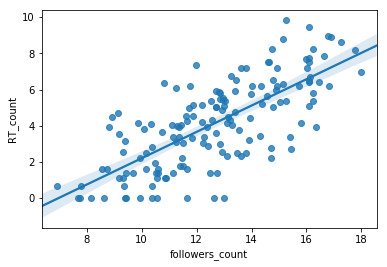

In [351]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
dedup_RT_category_counts = RT_category_counts.drop_duplicates('screen_name', inplace=False)
sns.regplot(np.log(dedup_RT_category_counts.loc[:, 'followers_count']), np.log(dedup_RT_category_counts.loc[:, 'RT_count']))
plt.show()

More popular accounts get more shares, surprise.

### Check cultural affinity among musician sharers
Now that we have sharing information, let's try to find accounts that are especially likely to share from one type of musician.

In [372]:
matched_verified_musician_twitter_data = matched_verified_musician_twitter_data.assign(**{
    'screen_name_clean' : matched_verified_musician_twitter_data.loc[:, 'screen_name'].apply(lambda x: x.lower())
})

In [377]:
matched_verified_musician_twitter_data.head()

,name,wiki_url,category,screen_name,followers_count,screen_name_lower,screen_name_clean
0,Christina Aguilera,/wiki/Christina_Aguilera,Latin_pop_singers,xtina,17027544,xtina,xtina
1,Christina Aguilera,/wiki/Christina_Aguilera,American_female_pop_singers,xtina,17027544,xtina,xtina
2,Paulina Aguirre,/wiki/Paulina_Aguirre,Latin_pop_singers,paulinaaguirre7,5553,paulinaaguirre7,paulinaaguirre7
3,Anahí,/wiki/Anah%C3%AD,Latin_pop_singers,Anahi,9846446,anahi,anahi
4,Anitta,/wiki/Anitta_(singer),Latin_pop_singers,Anitta,9888402,anitta,anitta


In [385]:
# get rid of doubles e.g. Christina Aguilera
dedup_matched_verified_musician_twitter_data = []
for name_i, data_i in matched_verified_musician_twitter_data.groupby('name'):
    if(data_i.shape[0] == 1):
        dedup_matched_verified_musician_twitter_data.append(data_i)
dedup_matched_verified_musician_twitter_data = pd.concat(dedup_matched_verified_musician_twitter_data, axis=0)
display(dedup_matched_verified_musician_twitter_data.head())
print(dedup_matched_verified_musician_twitter_data.loc[:, 'category'].value_counts())

,name,wiki_url,category,screen_name,followers_count,screen_name_lower,screen_name_clean
162,AJ McLean,/wiki/AJ_McLean,American_male_pop_singers,aj_mclean,369860,aj_mclean,aj_mclean
168,AJ Mitchell,/wiki/AJ_Mitchell,American_male_pop_singers,ajmitchell,384026,ajmitchell,ajmitchell
125,AM,/wiki/AM_(musician),American_male_pop_singers,AstonMerrygold,196793,astonmerrygold,astonmerrygold
61,Aaliyah,/wiki/Aaliyah,American_female_pop_singers,AaliyahHaughton,123017,aaliyahhaughton,aaliyahhaughton
36,Abraham Mateo,/wiki/Abraham_Mateo,Latin_pop_singers,AbrahamMateo,2990205,abrahammateo,abrahammateo


American_female_pop_singers    62
American_male_pop_singers      60
Latin_pop_singers              57
Name: category, dtype: int64


In [388]:
# convert to DF for easier manipulation
musician_sharing_data = pd.DataFrame(filtered_res)
# add name of shared person
RT_name_matcher = re.compile('(?<=^RT @)([a-zA-Z_0-9]+)')
musician_sharing_data = musician_sharing_data.assign(**{
    'share_source' : musician_sharing_data.loc[:, 'text'].apply(lambda x: RT_name_matcher.search(x).group(0).lower())
})
# add musician category
musician_sharing_data = pd.merge(musician_sharing_data, dedup_matched_verified_musician_twitter_data.loc[:, ['screen_name_clean', 'category']], left_on='share_source', right_on='screen_name_clean', how='inner').drop('screen_name_clean', axis=1, inplace=False)
print('%d/%d data with unambiguous musicians'%(musician_sharing_data.shape[0], len(filtered_res)))
display(musician_sharing_data.head())

105557/249516 data with unambiguous musicians


,text,id,created_at,user_id,user_screen_name,lang,lang_score,user_description,user_location,share_source,category
0,RT @DavidDeMaria: @diariodejerez @tiopepefesti...,1031808292522283009,Tue Aug 21 07:40:41 +0000 2018,633079953,Joannyaprendiz,es,99,"Amo el arte y la música, pinto por vocación.Ut...","Mahadahonda, Madrid-España",daviddemaria,Latin_pop_singers
1,RT @DavidDeMaria: https://t.co/sU8xaABNCt ...T...,1018092905825697792,Sat Jul 14 11:20:38 +0000 2018,467458709,anamgarciag,es,98,NaN,NaN,daviddemaria,Latin_pop_singers
2,RT @DavidDeMaria: #Sevilla #21deseptiembre #gi...,1014058534856724480,Tue Jul 03 08:09:29 +0000 2018,1631498599,DDM_Valencia,es,99,Delegación David DeMaría Valencia(club fans of...,Valencia,daviddemaria,Latin_pop_singers
3,RT @DavidDeMaria: #Sevilla #21deseptiembre #gi...,1016622475139002368,Tue Jul 10 09:57:40 +0000 2018,97674133,NHC_Fotografa,es,99,pasito a pasito para llegar al final amante de...,MADRID,daviddemaria,Latin_pop_singers
4,RT @DavidDeMaria: Me encanta este gallo 🐓 “bai...,1021853581723545603,Tue Jul 24 20:24:13 +0000 2018,843007742608588801,JoaCapricornio,es,98,Solo sé que no sé nada. Me encanta los planeta...,"Madrid, Comunidad de Madrid",daviddemaria,Latin_pop_singers


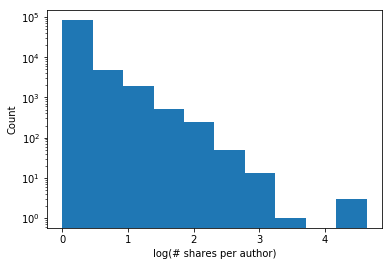

In [389]:
# how many authors share more than once?
musician_sharing_author_counts = musician_sharing_data.loc[:, 'user_screen_name'].value_counts()
plt.hist(np.log(musician_sharing_author_counts))
plt.yscale('log')
plt.ylabel('Count')
plt.xlabel('log(# shares per author)')
plt.show()

OK! We have a long tail of over-sharers.

In [391]:
min_share_count = 5
consistent_sharing_authors = musician_sharing_author_counts[musician_sharing_author_counts >= min_share_count].index.tolist()
print('%d/%d valid sharing authors'%(len(consistent_sharing_authors), len(musician_sharing_author_counts)))

824/91299 valid sharing authors


Compute % of shares from US American and Latin American musicians.

In [392]:
consistent_musician_sharing_data = musician_sharing_data[musician_sharing_data.loc[:, 'user_screen_name'].isin(consistent_sharing_authors)]
print('%d/%d data by consistent authors'%(consistent_musician_sharing_data.shape[0], musician_sharing_data.shape[0]))

5860/105557 data by consistent authors


In [395]:
latin_musician_categories = ['Latin_pop_singers']
us_musician_categories = ['American_male_pop_singers', 'American_female_pop_singers']
latin_musician_category_sharing_pcts = consistent_musician_sharing_data.groupby('user_screen_name').apply(lambda x: x[x.loc[:, 'category'].isin(latin_musician_categories)].shape[0] / x.shape[0])
us_musician_category_sharing_pcts = consistent_musician_sharing_data.groupby('user_screen_name').apply(lambda x: x[x.loc[:, 'category'].isin(us_musician_categories)].shape[0] / x.shape[0])

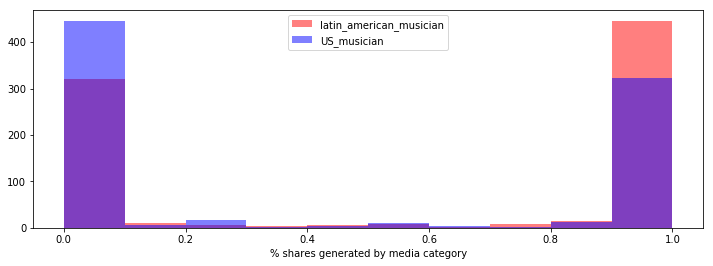

In [401]:
bin_count = 10
bins = np.linspace(0, 1., bin_count+1)
plt.figure(figsize=(12, 4))
plt.hist(latin_musician_category_sharing_pcts, bins=bins, color='r', alpha=0.5, label='latin_american_musician')
plt.hist(us_musician_category_sharing_pcts, bins=bins, color='b', alpha=0.5, label='US_musician')
plt.xlabel('% shares generated by media category')
plt.legend(loc='upper center')
plt.show()

Spoiler: most people tend to share music from one category.

### Find Twitter locals

Let's see if we can get any consistent differences between people with high affinity toward Latin American musicians and people with high affinity toward US American musicians.

In [404]:
# what are some consistent author characteristics that we can extract...HMM
# location?
print(consistent_musician_sharing_data.loc[:, 'user_location'].value_counts().head(20))

Tokyo                             199
Brasil                            110
México                             83
United States                      75
Las Palmas de Gran Canaria, Is     71
Buenos Aires, Argentina            46
Argentina                          45
São Paulo, Brasil                  42
Ecuador                            40
España                             38
Los Angeles, CA                    37
Rio de Janeiro, Brasil             37
Lima, Peru                         35
Indonesia                          32
🇧🇷                                 31
Morelos, México                    30
Chile                              29
Memphis, TN                        27
Orlando Florida                    27
Córdoba, Argentina                 26
Name: user_location, dtype: int64


OK! Most locations are either in US or Latin America: shocker.

Let's do some very basic string matching on gazetteer data:
- X contains name of Latin American country => author is from Latin America
- X contains name of US state => author is from US

In [420]:
geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False, usecols=['name', 'alternate_names', 'feature_class', 'feature_code', 'country', 'population', 'latitude', 'longitude'])
display(geonames_data.head())

,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population
0,Pic de Font Blanca,"Pic de Font Blanca,Pic du Port",42.64991,1.53335,T,PK,AD,0
1,Roc Mélé,"Roc Mele,Roc Meler,Roc Mélé",42.58765,1.74028,T,MT,AD,0
2,Pic des Langounelles,Pic des Langounelles,42.61203,1.47364,T,PK,AD,0
3,Pic de les Abelletes,"Pic de la Font-Negre,Pic de la Font-Nègre,Pic ...",42.52535,1.73343,T,PK,AD,0
4,Estany de les Abelletes,"Estany de les Abelletes,Etang de Font-Negre,Ét...",42.52915,1.73362,H,LK,AD,0


Collect all countries within South American bounds.

In [436]:
import re
country_feat_code = 'PCLI'
latin_america_bounds = [[26.512, -58.354], [-116.893, -32.444]]
latin_america_geonames = geonames_data[(geonames_data.loc[:, 'latitude'] <= latin_america_bounds[0][0]) &
                                       (geonames_data.loc[:, 'latitude'] >= latin_america_bounds[0][1]) &
                                       (geonames_data.loc[:, 'longitude'] >= latin_america_bounds[1][0]) &
                                       (geonames_data.loc[:, 'longitude'] <= latin_america_bounds[1][1])]
country_prefix = re.compile('^.+ of ')
country_rename_pairs = [(re.compile('Argentine Republic'), 'Argentina')]
latin_america_country_geonames = latin_america_geonames[latin_america_geonames.loc[:, 'feature_code']==country_feat_code]
latin_america_country_geonames = latin_america_country_geonames.assign(**{
    'name' : latin_america_country_geonames.loc[:, 'name'].apply(lambda x: country_prefix.sub('', x))
})
for country_name_matcher, country_rename in country_rename_pairs:
    latin_america_country_geonames = latin_america_country_geonames.assign(**{
        'name' : latin_america_country_geonames.loc[:, 'name'].apply(lambda x: country_name_matcher.sub(country_rename, x))
    })
# add extra names
latin_america_country_names = latin_america_country_geonames.loc[:, 'name'].values.tolist()
extra_country_names = ['Brasil']
latin_america_country_names += extra_country_names
print(latin_america_country_names)
# display(latin_america_geonames.sort_values('population', ascending=False).head())

['Antigua and Barbuda', 'Argentina', 'Barbados', 'Bolivia', 'Brazil', 'The Bahamas', 'Belize', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador', 'Grenada', 'Guatemala', 'Guyana', 'Honduras', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis', 'Saint Lucia', 'Mexico', 'Nicaragua', 'Panama', 'Peru', 'Paraguay', 'Suriname', 'El Salvador', 'Trinidad and Tobago', 'Uruguay', 'Saint Vincent and the Grenadines', 'Venezuela', 'Brasil']


Collect all (continental) US states.

In [448]:
us_bounds = [[49.137, 24.748], [-127.052, -68.279]]
state_feat_code = 'ADM1'
# us_geonames = geonames_data[(geonames_data.loc[:, 'latitude'] <= us_bounds[0][0]) &
#                             (geonames_data.loc[:, 'latitude'] >= us_bounds[0][1]) &
#                             (geonames_data.loc[:, 'longitude'] >= us_bounds[1][0]) &
#                             (geonames_data.loc[:, 'longitude'] <= us_bounds[1][1])]
us_geonames = geonames_data[geonames_data.loc[:, 'country']=='US']
us_state_geonames = us_geonames[us_geonames.loc[:, 'feature_code']==state_feat_code]
display(us_state_geonames.head())

,name,alternate_names,latitude,longitude,feature_class,feature_code,country,population
9110514,Arkansas,"'Akanaka,A-khen-set,AR,Akennsas,Arcansas,Arcan...",34.75037,-92.50044,A,ADM1,US,2757631
9148629,District of Columbia,"D.C.,DC,District de Columbia,District of Colum...",38.91706,-77.00025,A,ADM1,US,552433
9152717,Delaware,"DE,Delauaare,Delauare,Delaue""r,Delavar,Delavar...",39.00039,-75.49992,A,ADM1,US,838549
9166185,Florida,"FL,Floarida,Florid,Florida,Florida Shitati,Flo...",28.75054,-82.50010,A,ADM1,US,17671452
9207263,Georgia,"Chacha,Dzhordzhija,Estado de Georgia,GA,Georgi...",32.75042,-83.50018,A,ADM1,US,8975842


In [449]:
# get names and alternate name (2-letter state abbreve)
us_state_names = us_state_geonames.loc[:, 'name'].values.tolist()
state_abbreve_matcher = re.compile('[A-Z]{2}')
us_state_abbreve_names = us_state_geonames.loc[:, 'alternate_names'].apply(lambda x: list(filter(lambda y: state_abbreve_matcher.search(y) is not None, x.split(',')))[0]).values.tolist()
# us_abbreve_state_lookup = dict(zip(us_state_abbreve_names, us_state_names))
# print(us_abbreve_state_lookup)

Great. Now let's approximate US locals and Latin American locals using country names.

In [463]:
latin_america_country_matcher = re.compile('(%s)$'%('|'.join(list(map(lambda x: x.lower(), latin_america_country_names)))))
us_state_abbreve_names_combined = us_state_names + us_state_abbreve_names
us_state_matcher = re.compile(', (%s)$|^(%s)$'%('|'.join(list(map(lambda x: x.lower(), us_state_abbreve_names_combined))), '|'.join(list(map(lambda x: x.lower(), us_state_names)))))
# us_state_matcher = re.compile(', (%s)$'%('|'.join(list(map(lambda x: x.lower(), us_state_abbreve_names_combined)))))
print(latin_america_country_matcher.pattern)
print(us_state_matcher.pattern)

(antigua and barbuda|argentina|barbados|bolivia|brazil|the bahamas|belize|chile|colombia|costa rica|cuba|dominica|dominican republic|ecuador|grenada|guatemala|guyana|honduras|haiti|jamaica|saint kitts and nevis|saint lucia|mexico|nicaragua|panama|peru|paraguay|suriname|el salvador|trinidad and tobago|uruguay|saint vincent and the grenadines|venezuela|brasil)$
, (arkansas|district of columbia|delaware|florida|georgia|kansas|louisiana|maryland|missouri|mississippi|north carolina|oklahoma|south carolina|tennessee|texas|west virginia|alabama|connecticut|iowa|illinois|indiana|maine|michigan|minnesota|nebraska|new hampshire|new jersey|new york|ohio|rhode island|vermont|wisconsin|california|colorado|new mexico|nevada|utah|arizona|idaho|montana|north dakota|oregon|south dakota|washington|wyoming|hawaii|alaska|kentucky|massachusetts|pennsylvania|virginia|ar|dc|de|fl|ga|ks|la|md|mo|ms|nc|ok|sc|tn|tx|wv|al|ct|ia|il|in|me|mi|mn|ne|nh|nj|ny|oh|ri|vt|wi|ca|co|nm|nv|ut|az|id|mt|nd|or|sd|wa|wy|hi|ak|k

In [462]:
assert latin_america_country_matcher.search('sao paolo, brazil') is not None
assert us_state_matcher.search('orlando, fl') is not None
assert us_state_matcher.search('florida') is not None

Label time.

In [471]:
def clean_str(s):
    s = unidecode(s)
    s = s.lower()
    return s
musician_sharing_author_loc_data = consistent_musician_sharing_data.loc[:, ['user_screen_name', 'user_location']].drop_duplicates('user_screen_name', inplace=False)
musician_sharing_author_loc_data = musician_sharing_author_loc_data.assign(**{
    'user_location' : musician_sharing_author_loc_data.loc[:, 'user_location'].apply(lambda x: clean_str(x) if type(x) is str else x)
})
musician_sharing_author_loc_data = musician_sharing_author_loc_data.assign(**{
    'user_is_local_to_us' : musician_sharing_author_loc_data.loc[:, 'user_location'].apply(lambda x: type(x) is str and us_state_matcher.search(x) is not None),
    'user_is_local_to_latin_america' : musician_sharing_author_loc_data.loc[:, 'user_location'].apply(lambda x: type(x) is str and latin_america_country_matcher.search(x) is not None),
})

In [473]:
# get local counts
print('%d US-local authors'%(musician_sharing_author_loc_data.loc[:, 'user_is_local_to_us'].sum()))
print('%d Latin America-local authors'%(musician_sharing_author_loc_data.loc[:, 'user_is_local_to_latin_america'].sum()))

45 US-local authors
211 Latin America-local authors


Better than nothing? Let's compare the rate of sharing US musicians and Latin American musicians.

### Compare musician sharing rates among locals

In [488]:
# consistent_musician_sharing_local_data = pd.merge(consistent_musician_sharing_data, musician_sharing_author_loc_data.loc[:, ['user_screen_name', 'user_is_local_to_us', 'user_is_local_to_latin_america']], on='user_screen_name')
# display(consistent_musician_sharing_local_data.head())
# print(consistent_musician_sharing_local_data.shape[0])
latin_musician_categories = ['Latin_pop_singers']
us_musician_categories = ['American_male_pop_singers', 'American_female_pop_singers']
us_local_authors = musician_sharing_author_loc_data[musician_sharing_author_loc_data.loc[:, 'user_is_local_to_us']].loc[:, 'user_screen_name']
latin_america_local_authors = musician_sharing_author_loc_data[musician_sharing_author_loc_data.loc[:, 'user_is_local_to_latin_america']].loc[:, 'user_screen_name']
us_local_consistent_musician_sharing_data = consistent_musician_sharing_data[consistent_musician_sharing_data.loc[:, 'user_screen_name'].isin(us_local_authors)]
latin_america_local_consistent_musician_sharing_data = consistent_musician_sharing_data[consistent_musician_sharing_data.loc[:, 'user_screen_name'].isin(latin_america_local_authors)]
us_local_us_musician_pcts = us_local_consistent_musician_sharing_data.groupby('user_screen_name').apply(lambda x: x[x.loc[:, 'category'].isin(us_musician_categories)].shape[0] / x.shape[0])
latin_america_local_us_musician_pcts = latin_america_local_consistent_musician_sharing_data.groupby('user_screen_name').apply(lambda x: x[x.loc[:, 'category'].isin(us_musician_categories)].shape[0] / x.shape[0])
us_local_latin_musician_pcts = us_local_consistent_musician_sharing_data.groupby('user_screen_name').apply(lambda x: x[x.loc[:, 'category'].isin(latin_musician_categories)].shape[0] / x.shape[0])
latin_america_local_latin_musician_pcts = latin_america_local_consistent_musician_sharing_data.groupby('user_screen_name').apply(lambda x: x[x.loc[:, 'category'].isin(latin_musician_categories)].shape[0] / x.shape[0])

Hypothesis test: are Latin American locals more likely to share posts from Latin American musicians?

In [484]:
from scipy.stats import wilcoxon
def compare_pcts(data_1, data_2):
    median_diff = (data_1 - data_2).median()
    test_stat, p_val = wilcoxon(data_1, data_2)
    return median_diff, test_stat, p_val

$d = \text{US_musician_share_pct} - \text{Latin_musician_share_pct}$

In [490]:
local_author_categories = ['us_local', 'latin_american_local']
for cat_i, (pct_1, pct_2) in zip(local_author_categories, zip([us_local_us_musician_pcts, latin_america_local_us_musician_pcts], [us_local_latin_musician_pcts, latin_america_local_latin_musician_pcts])):
    print('category = %s'%(cat_i))
    median_diff, test_stat, p_val = compare_pcts(pct_1, pct_2)
    print('median diff = %.3f, stat=%.3f (p=%.3E, N=%d)'%(median_diff, test_stat, p_val, len(pct_1)))

category = us_local
median diff = 1.000, stat=164.500 (p=5.927E-06, N=45)
category = latin_american_local
median diff = -1.000, stat=2655.000 (p=1.401E-27, N=211)


Sanity check complete! Latin American locals tend to share more Latin American musicians.

Update: we need to compare Latin American local population vs. US American local population.

In [491]:
us_local_consistent_musician_sharing_data.head()

,text,id,created_at,user_id,user_screen_name,lang,lang_score,user_description,user_location,share_source,category
1332,"RT @AbrahamMateo: Esta vez, Lo Que Pasa En Las...",1121359551821963264,2019-04-25T10:25:25+00:00,1113025634865963008,idalia_frias,es,99,Sigueme en Instagram: Idalia1528 y Facebook: I...,"Scranton, PA",abrahammateo,Latin_pop_singers
6474,RT @alexoficial: #PedroInfante se fue hace 62 ...,1117940338428129281,2019-04-15T23:58:41+00:00,1113025634865963008,idalia_frias,es,99,Sigueme en Instagram: Idalia1528 y Facebook: I...,"Scranton, PA",alexoficial,Latin_pop_singers
6728,RT @enriqueiglesias: 10 million views already!...,1031796011583385600,Tue Aug 21 06:51:53 +0000 2018,1031476083760214016,Enrique80816,en,98,Official Enrique Iglesias Twitter. “I Don’t Da...,"Miami, FL",enriqueiglesias,Latin_pop_singers
6749,RT @enriqueiglesias: Sounds great on Ukelele @...,1031649445815955457,Mon Aug 20 21:09:29 +0000 2018,1031476083760214016,Enrique80816,en,98,Official Enrique Iglesias Twitter. “I Don’t Da...,"Miami, FL",enriqueiglesias,Latin_pop_singers
6789,RT @enriqueiglesias: this is how much love I g...,1031487944161468416,Mon Aug 20 10:27:44 +0000 2018,1031476083760214016,Enrique80816,en,99,Official Enrique Iglesias Twitter. “I Don’t Da...,"Miami, FL",enriqueiglesias,Latin_pop_singers


In [513]:
from numpy.linalg import norm
from scipy.stats import fisher_exact
us_local_us_musician_count = us_local_consistent_musician_sharing_data.loc[:, 'category'].apply(lambda x: x in us_musician_categories).sum()
us_local_latin_american_musician_count = us_local_consistent_musician_sharing_data.loc[:, 'category'].apply(lambda x: x in latin_musician_categories).sum()
latin_america_local_us_musician_count = latin_america_local_consistent_musician_sharing_data.loc[:, 'category'].apply(lambda x: x in us_musician_categories).sum()
latin_america_local_latin_american_musician_count = latin_america_local_consistent_musician_sharing_data.loc[:, 'category'].apply(lambda x: x in latin_musician_categories).sum()
contingency_table = pd.DataFrame([
    [us_local_us_musician_count, us_local_latin_american_musician_count],
    [latin_america_local_us_musician_count, latin_america_local_latin_american_musician_count]
], columns=['US_musician_shares', 'Latin_American_musician_shares'], index=['US_local', 'Latin_American_local'])
norm_contingency_table = (contingency_table.T / contingency_table.sum(axis=1)).T
print('raw counts')
print(contingency_table)
print('norm counts')
print(norm_contingency_table)
test_stat, p_val = fisher_exact(contingency_table, alternative='two-sided')
print('difference is significant with stat=%.3f (p=%.3E)'%(test_stat, p_val))

raw counts
                      US_musician_shares  Latin_American_musician_shares
US_local                             257                              46
Latin_American_local                 193                            1247
norm counts
                      US_musician_shares  Latin_American_musician_shares
US_local                        0.848185                        0.151815
Latin_American_local            0.134028                        0.865972
difference is significant with stat=36.098 (p=1.120E-131)


Conclusion: US locals tend to share US musicians, Latin American locals tend to share Latin American musicians.

Next question: what can we say about locals who share music from the other culture?

### Test coverage of full pop musician lists
Now that we've collected the full pop music lists [here](collect_twitter_screen_names.py), let's assess the coverage on Twitter again.

- RT %
- @-mention %
- local approximation (with city-name matching)
- local approximation (geolocation?? try [demographer](https://bitbucket.org/mdredze/demographer/src/updates2020/))

In [533]:
us_american_musician_twitter_data = pd.read_csv('../../data/culture_metadata/us_american_pop_musicians_en_twitter_screen_names.tsv', sep='\t', index_col=False)
latin_american_musician_en_twitter_data = pd.read_csv('../../data/culture_metadata/latin_american_pop_musicians_en_twitter_screen_names.tsv', sep='\t', index_col=False)
latin_american_musician_es_twitter_data = pd.read_csv('../../data/culture_metadata/latin_american_pop_musicians_es_twitter_screen_names.tsv', sep='\t', index_col=False)
latin_american_musician_twitter_data = pd.concat([latin_american_musician_en_twitter_data, latin_american_musician_es_twitter_data], axis=0).drop_duplicates('name', inplace=False)

In [534]:
latin_american_musician_twitter_data.head()

,name,screen_name,followers
0,Dorismar,DorismarTv,144466
1,Valeria Gastaldi,valeriagastaldi,37302
2,Hilda Lizarazu,lizarazuok,27969
3,Benjamín Rojas,rojasbenjamin,1276268
4,Julián Serrano,JulianSerrano01,2486963


In [535]:
us_american_musician_names = us_american_musician_twitter_data.loc[:, 'screen_name'].apply(lambda x: '@%s'%(x.lower())).values.tolist()
latin_american_musician_names = latin_american_musician_twitter_data.loc[:, 'screen_name'].apply(lambda x: '@%s'%(x.lower())).values.tolist()
# remove overlap
us_american_latin_american_overlap_names = set(us_american_musician_names) & set(latin_american_musician_names)
print('%d overlap'%(len(us_american_latin_american_overlap_names)))
us_american_musician_names = list(set(us_american_musician_names) - us_american_latin_american_overlap_names)
latin_american_musician_names = list(set(latin_american_musician_names) - us_american_latin_american_overlap_names)
print('%d US American names'%(len(us_american_musician_names)))
print('%d Latin American names'%(len(latin_american_musician_names)))

3 overlap
259 US American names
174 Latin American names


Unsurprisingly more Latin American names because we had two sets of names (EN/ES).

In [537]:
def generate_es_queries_by_chunk(query_str_list, match_var='text'):
    """
    Generate ES queries by chunking list of query values.
    """
    # chunks
    MAX_CHUNK_SIZE = 50
    name_chunk_count = int(ceil(len(query_str_list) / MAX_CHUNK_SIZE))
    name_chunks = [query_str_list[(i*MAX_CHUNK_SIZE):((i+1)*MAX_CHUNK_SIZE)] for i in range(name_chunk_count)]
    es_queries = []
    for name_chunk in name_chunks:
        name_str = '|'.join(name_chunk)
        es_query = {
            'query' : {
                'match' : {
                    match_var : name_str
                }
            }
        }
        es_queries.append(es_query)
    return es_queries

In [538]:
combined_musician_names = us_american_musician_names + latin_american_musician_names
musician_es_queries = generate_es_queries_by_chunk(combined_musician_names)
print(musician_es_queries)

[{'query': {'match': {'text': '@mariahcarey|@michaeljackson|@jtimberlake|@tameladamico|@ramielemalubay|@msteenamarie|@stacybarthe|@jerryleelewis|@barbrastreisand|@gloriagaynor|@_dionnewarwick|@taylordayne|@iamreginabelle|@latoyajackson|@singerlilsuzy|@davidarchie|@parisstweets|@carole_king|@ravensymone|@robynadele|@msanamatronic|@therealsophieb|@sirjacksplash|@katrinapmusic|@janamashonee|@luthervandross|@aubreyoday|@diamondwhite|@kerihilson|@santayemusic|@daphnewillis|@billyjoel|@meghan_trainor|@januaryvjones|@mauricewhiteewf|@carovreeland|@brittonbuchanan|@aaliyahhaughton|@jlo|@joy_villa|@jimmybuffett|@brian_littrell|@lacefield|@keyshiacole|@beberexha|@tamarkaprelian|@ashleytisdale|@michellechamuel|@lindsaylohan|@sabrinabryan'}}}, {'query': {'match': {'text': '@tarynsouthern|@selenagomez|@8ierrakay|@debbiegibson|@leamichele|@tonyorlando|@shaniceonline|@beckahshae|@kellyclarkson|@britneyspears|@themarciahines|@clayaiken|@manikaofficial|@jsutta|@vikkicarroffcl|@samleecole|@bonniemckee|@

In [539]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import execute_queries_all_instances
# print(es_queries)
es_query_results = []
es_cluster_name = 'twitter_posts'
es_ye
ar_month_pairs = [(2018, 1, 3), (2018, 4, 6), (2018, 7, 9), (2018, 10, 12), (2019, 1, 3), (2019, 4, 6)]
es_base_dir = '/hg190/elastic_search/'
es_query_result = execute_queries_all_instances(musician_es_queries, 
                                                es_year_month_pairs=es_year_month_pairs,
                                                es_cluster_name=es_cluster_name,
                                                es_base_dir=es_base_dir, verbose=True)
# collapse
es_query_result = list(reduce(lambda x,y: x+y, es_query_result))

starting index twitter_posts_2018_m_1_3
sleeping for 150 sec to wait for ES to initialize
starting index twitter_posts_2018_m_4_6
sleeping for 150 sec to wait for ES to initialize
starting index twitter_posts_2018_m_7_9
sleeping for 150 sec to wait for ES to initialize
starting index twitter_posts_2018_m_10_12
sleeping for 150 sec to wait for ES to initialize
starting index twitter_posts_2019_m_1_3
sleeping for 150 sec to wait for ES to initialize
starting index twitter_posts_2019_m_4_6
sleeping for 150 sec to wait for ES to initialize


In [544]:
print(len(es_query_result))
musician_es_query_result_data = pd.DataFrame(es_query_result)
musician_es_query_result_data = musician_es_query_result_data.assign(**{
    'text_clean' : musician_es_query_result_data.loc[:, 'text'].apply(lambda x: x.lower())
})
display(musician_es_query_result_data.head())

1622056


,text,id,created_at,user_id,user_description,user_screen_name,user_location,lang,lang_score,text_clean
0,RT @456List: Watch https://t.co/qEy3zVUTnG\n#m...,953292444157833216,2018-01-16T15:46:44+00:00,75709914,As seen on OPRAH! Post Anything U Like-.Jobs ...,456List,usa,en,99,rt @456list: watch https://t.co/qey3zvutng\n#m...
1,RT @latoyajackson: I recall this night so well...,958037619669176328,2018-01-29T18:02:22+00:00,2221887969,vis tes reves🕶 tant que tu peux encore 📱 il e...,InesSANTA3,Les Bres,en,99,rt @latoyajackson: i recall this night so well...
2,@TwitterMusic @jtimberlake @JLo @XAmbassadors ...,959543383185346561,2018-02-02T21:45:44+00:00,953695692068933632,NaN,24_aggelos,NaN,en,98,@twittermusic @jtimberlake @jlo @xambassadors ...
3,@4EverDW @MsTeenaMarie truth!,949353724262182912,2018-01-05T18:55:40+00:00,24776235,Donnie Wahlberg - Human Being / Father / Husba...,DonnieWahlberg,US,en,96,@4everdw @msteenamarie truth!
4,RT @latoyajackson: I recall this night so well...,957789769827840001,2018-01-29T01:37:30+00:00,380621886,DAF-nee: (Means laurel)\r\nWelcome 2 my Twitte...,vicky3278,Georgia/New Jersey,en,99,rt @latoyajackson: i recall this night so well...


In [576]:
## tmp: write to file!!
musician_es_query_result_data.to_csv('../../data/mined_tweets/us_american_latin_american_musician_mentions_twitter_search_results.gz', sep='\t', index=False, compression='gzip')

How many RTs did we get?

In [550]:
import re
# combined_screen_name_str = '|'.join(combined_musician_names)
# RT_matcher = re.compile(f'RT ({combined_screen_name_str})')
RT_matcher = re.compile('(?<=^rt @)[a-z0-9_]+')
mention_matcher = re.compile('(?<=@)[a-z0-9_]+')
musician_es_query_result_data = musician_es_query_result_data.assign(**{
    'RT_mention' : musician_es_query_result_data.loc[:, 'text_clean'].apply(lambda x: RT_matcher.search(x).group(0) if RT_matcher.search(x) is not None else None),
    'mentions' : musician_es_query_result_data.loc[:, 'text_clean'].apply(lambda x: mention_matcher.findall(x))
})
display(musician_es_query_result_data.head())

,text,id,created_at,user_id,user_description,user_screen_name,user_location,lang,lang_score,text_clean,RT_mention,mentions
0,RT @456List: Watch https://t.co/qEy3zVUTnG\n#m...,953292444157833216,2018-01-16T15:46:44+00:00,75709914,As seen on OPRAH! Post Anything U Like-.Jobs ...,456List,usa,en,99,rt @456list: watch https://t.co/qey3zvutng\n#m...,456list,"[456list, latoyajackson]"
1,RT @latoyajackson: I recall this night so well...,958037619669176328,2018-01-29T18:02:22+00:00,2221887969,vis tes reves🕶 tant que tu peux encore 📱 il e...,InesSANTA3,Les Bres,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson]
2,@TwitterMusic @jtimberlake @JLo @XAmbassadors ...,959543383185346561,2018-02-02T21:45:44+00:00,953695692068933632,NaN,24_aggelos,NaN,en,98,@twittermusic @jtimberlake @jlo @xambassadors ...,None,"[twittermusic, jtimberlake, jlo, xambassadors,..."
3,@4EverDW @MsTeenaMarie truth!,949353724262182912,2018-01-05T18:55:40+00:00,24776235,Donnie Wahlberg - Human Being / Father / Husba...,DonnieWahlberg,US,en,96,@4everdw @msteenamarie truth!,None,"[4everdw, msteenamarie]"
4,RT @latoyajackson: I recall this night so well...,957789769827840001,2018-01-29T01:37:30+00:00,380621886,DAF-nee: (Means laurel)\r\nWelcome 2 my Twitte...,vicky3278,Georgia/New Jersey,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson]


In [557]:
clean_combined_musician_names = set(map(lambda x: x.replace('@', ''), combined_musician_names))
# restrict to musicians
musician_es_query_result_data = musician_es_query_result_data.assign(**{
    'RT_mention_musician' : musician_es_query_result_data.loc[:, 'RT_mention'].apply(lambda x: x if x in clean_combined_musician_names else None),
    'mentions_musician' : musician_es_query_result_data.loc[:, 'mentions'].apply(lambda x: list(set(x) & clean_combined_musician_names))
})
display(musician_es_query_result_data.head())

,text,id,created_at,user_id,user_description,user_screen_name,user_location,lang,lang_score,text_clean,RT_mention,mentions,RT_mention_musician,mentions_musician
0,RT @456List: Watch https://t.co/qEy3zVUTnG\n#m...,953292444157833216,2018-01-16T15:46:44+00:00,75709914,As seen on OPRAH! Post Anything U Like-.Jobs ...,456List,usa,en,99,rt @456list: watch https://t.co/qey3zvutng\n#m...,456list,"[456list, latoyajackson]",None,[latoyajackson]
1,RT @latoyajackson: I recall this night so well...,958037619669176328,2018-01-29T18:02:22+00:00,2221887969,vis tes reves🕶 tant que tu peux encore 📱 il e...,InesSANTA3,Les Bres,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,[latoyajackson]
2,@TwitterMusic @jtimberlake @JLo @XAmbassadors ...,959543383185346561,2018-02-02T21:45:44+00:00,953695692068933632,NaN,24_aggelos,NaN,en,98,@twittermusic @jtimberlake @jlo @xambassadors ...,None,"[twittermusic, jtimberlake, jlo, xambassadors,...",None,"[jtimberlake, jlo]"
3,@4EverDW @MsTeenaMarie truth!,949353724262182912,2018-01-05T18:55:40+00:00,24776235,Donnie Wahlberg - Human Being / Father / Husba...,DonnieWahlberg,US,en,96,@4everdw @msteenamarie truth!,None,"[4everdw, msteenamarie]",None,[msteenamarie]
4,RT @latoyajackson: I recall this night so well...,957789769827840001,2018-01-29T01:37:30+00:00,380621886,DAF-nee: (Means laurel)\r\nWelcome 2 my Twitte...,vicky3278,Georgia/New Jersey,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,[latoyajackson]


In [559]:
from functools import reduce
musician_mentions_combined = []
for musician_mentions in musician_es_query_result_data.loc[:, 'mentions_musician']:
    musician_mentions_combined += musician_mentions
musician_mention_counts = pd.Series(musician_mentions_combined).value_counts().sort_values(inplace=False, ascending=False)
display(musician_mention_counts.head(20))
RT_mentions_combined = musician_es_query_result_data[musician_es_query_result_data.loc[:, 'RT_mention_musician'].apply(lambda x: x is not None)].loc[:, 'RT_mention_musician'].value_counts().sort_values(inplace=False, ascending=False)
display(RT_mentions_combined.head(20))

arianagrande      403157
taylorswift13     119541
thegreatkhalid     59206
ladygaga           55540
zendaya            49516
bettemidler        33475
alejandrosanz      28420
lanadelrey         24688
selenagomez        24176
beberexha          23891
normani            23696
chrisbrown         22326
cher               21013
mariahcarey        20008
madonna            19956
ciara              18228
britneyspears      15838
luceromexico       13041
jtimberlake        12817
jlo                12431
dtype: int64

arianagrande       206376
zendaya             41686
thegreatkhalid      22693
bettemidler         22532
ladygaga            20243
lanadelrey          16542
taylorswift13       13972
beberexha           12758
alejandrosanz       10478
chrisbrown          10287
mariahcarey          9111
cher                 8564
normani              7577
parishilton          7284
britneyspears        6191
julianserrano01      5995
hayleykiyoko         5624
madisonbeer          5588
madonna              5440
ciara                5339
Name: RT_mention_musician, dtype: int64

OK, we have a few hundred thousand tweets that match one of the musicians.

Who are the top artists per-category?

In [572]:
clean_us_american_musician_name_data = pd.DataFrame(list(map(lambda x: x.replace('@', ''), us_american_musician_names)), columns=['musician_name']).assign(**{'category' : 'US_american_musician'})
clean_latin_american_musician_name_data = pd.DataFrame(list(map(lambda x: x.replace('@', ''), latin_american_musician_names)), columns=['musician_name']).assign(**{'category' : 'Latin_american_musician'})
musician_name_category_data = pd.concat([clean_us_american_musician_name_data, clean_latin_american_musician_name_data], axis=0)
RT_category_es_query_result_data = pd.merge(musician_es_query_result_data, musician_name_category_data, left_on='RT_mention_musician', right_on='musician_name').drop('musician_name', axis=1, inplace=False).rename(columns={'category' : 'RT_mention_musician_category'})
display(RT_category_es_query_result_data.head())

,text,id,created_at,user_id,user_description,user_screen_name,user_location,lang,lang_score,text_clean,RT_mention,mentions,RT_mention_musician,mentions_musician,RT_mention_musician_category
0,RT @latoyajackson: I recall this night so well...,958037619669176328,2018-01-29T18:02:22+00:00,2221887969,vis tes reves🕶 tant que tu peux encore 📱 il e...,InesSANTA3,Les Bres,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,[latoyajackson],US_american_musician
1,RT @latoyajackson: I recall this night so well...,957789769827840001,2018-01-29T01:37:30+00:00,380621886,DAF-nee: (Means laurel)\r\nWelcome 2 my Twitte...,vicky3278,Georgia/New Jersey,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,[latoyajackson],US_american_musician
2,RT @latoyajackson: I recall this night so well...,957669225534955521,2018-01-28T17:38:30+00:00,953696442509557760,and Tag @DNRsMusic for a Retweet✌️ Only retw...,DNRsMusic,"Ontario, OH",en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,[latoyajackson],US_american_musician
3,RT @latoyajackson: I recall this night so well...,957759063353446400,2018-01-28T23:35:29+00:00,2814082377,"✨✨LOVER MUSIC♫, MOVIES, ROCK, POP, ¡Lover to V...",Ana20Leto,NaN,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,[latoyajackson],US_american_musician
4,RT @latoyajackson: #ThursdayThoughts https://t...,949053462435762177,2018-01-04T23:02:32+00:00,2993981110,"T ❤God ,My family, all different types of Musi...",Tmusiclover1,"Baltimore, MD",en,98,rt @latoyajackson: #thursdaythoughts https://t...,latoyajackson,[latoyajackson],latoyajackson,[latoyajackson],US_american_musician


In [573]:
for cat_i, data_i in RT_category_es_query_result_data.groupby('RT_mention_musician_category'):
    print('category=%s'%(cat_i))
    print(data_i.loc[:, 'RT_mention_musician'].value_counts().sort_values(inplace=False, ascending=False).head(20))

category=Latin_american_musician
alejandrosanz      10478
julianserrano01     5995
shakira             4491
luceromexico        3265
dulcemaria          2863
anitta              2769
abrahammateo        2500
montanertwiter      1885
germangarmendia     1722
_carlosrivera       1715
sebastianyatra      1488
axeloficial         1470
patycantu           1388
davidbisbal         1366
enriqueiglesias     1216
belindapop          1088
luisfonsi           1016
sherylrubior28       965
ricky_martin         925
dannapaola           882
Name: RT_mention_musician, dtype: int64
category=US_american_musician
arianagrande       206376
zendaya             41686
thegreatkhalid      22693
bettemidler         22532
ladygaga            20243
lanadelrey          16542
taylorswift13       13972
beberexha           12758
chrisbrown          10287
mariahcarey          9111
cher                 8564
normani              7577
parishilton          7284
britneyspears        6191
hayleykiyoko         5624
madison

OK! Way more US American musician mentions than Latin American musician mentions, duh.

Let's flatten the data and do the same thing with the mentions.

In [585]:
flat_mention_es_query_result_data = []
for i, data_i in musician_es_query_result_data.iterrows():
    for mention in data_i.loc['mentions_musician']:
        # series -> list -> add mention -> series (faster than series -> add -> series??)
        row = data_i.copy().drop('mentions_musician', inplace=False)
        row_idx = row.index.tolist() + ['mention_musician']
        row_vals = row.values.tolist()
        row_vals.append(mention)
        flat_mention_es_query_result_data.append(pd.Series(row_vals, index=row_idx))
flat_mention_es_query_result_data = pd.DataFrame(flat_mention_es_query_result_data)
display(flat_mention_es_query_result_data.head())
# combine with categories
mention_category_es_query_result_data = pd.merge(flat_mention_es_query_result_data, musician_name_category_data, left_on='mention_musician', right_on='musician_name').drop('musician_name', axis=1, inplace=False).rename(columns={'category' : 'mention_musician_category'})

In [594]:
## combine everything
musician_category_es_query_result_data = pd.merge(mention_category_es_query_result_data, 
                                                  RT_category_es_query_result_data.loc[:, ['id', 'RT_mention_musician_category']],
                                                  on='id', how='outer')
# drop duplicates
musician_category_es_query_result_data.drop_duplicates(['id', 'mention_musician'], inplace=True)
display(musician_category_es_query_result_data.head())

,text,id,created_at,user_id,user_description,user_screen_name,user_location,lang,lang_score,text_clean,RT_mention,mentions,RT_mention_musician,mention_musician,mention_musician_category,RT_mention_musician_category
0,RT @456List: Watch https://t.co/qEy3zVUTnG\n#m...,953292444157833216,2018-01-16T15:46:44+00:00,75709914,As seen on OPRAH! Post Anything U Like-.Jobs ...,456List,usa,en,99,rt @456list: watch https://t.co/qey3zvutng\n#m...,456list,"[456list, latoyajackson]",None,latoyajackson,US_american_musician,NaN
1,RT @latoyajackson: I recall this night so well...,958037619669176328,2018-01-29T18:02:22+00:00,2221887969,vis tes reves🕶 tant que tu peux encore 📱 il e...,InesSANTA3,Les Bres,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,latoyajackson,US_american_musician,US_american_musician
2,RT @latoyajackson: I recall this night so well...,957789769827840001,2018-01-29T01:37:30+00:00,380621886,DAF-nee: (Means laurel)\r\nWelcome 2 my Twitte...,vicky3278,Georgia/New Jersey,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,latoyajackson,US_american_musician,US_american_musician
3,RT @latoyajackson: I recall this night so well...,957669225534955521,2018-01-28T17:38:30+00:00,953696442509557760,and Tag @DNRsMusic for a Retweet✌️ Only retw...,DNRsMusic,"Ontario, OH",en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,latoyajackson,US_american_musician,US_american_musician
4,RT @latoyajackson: I recall this night so well...,957759063353446400,2018-01-28T23:35:29+00:00,2814082377,"✨✨LOVER MUSIC♫, MOVIES, ROCK, POP, ¡Lover to V...",Ana20Leto,NaN,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,latoyajackson,US_american_musician,US_american_musician


In [596]:
for cat_i, data_i in musician_category_es_query_result_data.groupby('mention_musician_category'):
    if(type(cat_i) is str):
        print('category=%s'%(cat_i))
        print(data_i.loc[:, 'mention_musician'].value_counts().sort_values(inplace=False, ascending=False).head(20))

category=Latin_american_musician
alejandrosanz      27536
luceromexico       12806
abrahammateo       11519
anitta             11514
julianserrano01    10532
shakira            10458
_carlosrivera      10209
dulcemaria          6952
axeloficial         6465
davidbisbal         5506
sebastianyatra      5450
luisfonsi           4717
thalia              4662
ricky_martin        4129
enriqueiglesias     3971
abelpintos          3674
belindapop          3538
patycantu           3516
montanertwiter      3452
germangarmendia     3228
Name: mention_musician, dtype: int64
category=US_american_musician
arianagrande      399102
taylorswift13     116026
thegreatkhalid     56481
ladygaga           52797
zendaya            49449
bettemidler        33339
lanadelrey         24545
beberexha          23219
selenagomez        22981
chrisbrown         22173
normani            21766
cher               20853
mariahcarey        19153
madonna            18812
ciara              18001
britneyspears      15224


### Geolocate authors who mention musicians
Let's try to geolocate the authors based on their self-reported location.

In [645]:
geonames_data = pd.read_csv('/hg190/corpora/GeoNames/allCountriesSimplified.tsv', sep='\t', index_col=False, usecols=['name', 'latitude', 'longitude', 'alternate_names', 'feature_class', 'feature_code', 'country', 'population'])
geonames_data = geonames_data.assign(**{
    'alternate_names' : geonames_data.loc[:, 'alternate_names'].apply(lambda x: x.split(',') if type(x) is str else x)
})
# get states
state_feat_code = 'ADM1'
us_geonames = geonames_data[geonames_data.loc[:, 'country']=='US']
us_state_geonames = us_geonames[us_geonames.loc[:, 'feature_code']==state_feat_code]
# get names and alternate name (2-letter state abbreve)
us_state_names = us_state_geonames.loc[:, 'name'].values.tolist()
state_abbreve_matcher = re.compile('[A-Z]{2}')
us_state_abbreve_names = us_state_geonames.loc[:, 'alternate_names'].apply(lambda x: list(filter(lambda y: state_abbreve_matcher.search(y) is not None, x))[0]).values.tolist()

In [647]:
# get Latin American countries
country_feat_code = 'PCLI'
latin_america_bounds = [[26.512, -58.354], [-116.893, -32.444]]
latin_america_geonames = geonames_data[(geonames_data.loc[:, 'latitude'] <= latin_america_bounds[0][0]) &
                                       (geonames_data.loc[:, 'latitude'] >= latin_america_bounds[0][1]) &
                                       (geonames_data.loc[:, 'longitude'] >= latin_america_bounds[1][0]) &
                                       (geonames_data.loc[:, 'longitude'] <= latin_america_bounds[1][1])]
country_prefix = re.compile('^.+ of ')
country_rename_pairs = [(re.compile('Argentine Republic'), 'Argentina')]
latin_america_country_geonames = latin_america_geonames[latin_america_geonames.loc[:, 'feature_code']==country_feat_code]
latin_america_country_geonames = latin_america_country_geonames.assign(**{
    'name' : latin_america_country_geonames.loc[:, 'name'].apply(lambda x: country_prefix.sub('', x))
})
for country_name_matcher, country_rename in country_rename_pairs:
    latin_america_country_geonames = latin_america_country_geonames.assign(**{
        'name' : latin_america_country_geonames.loc[:, 'name'].apply(lambda x: country_name_matcher.sub(country_rename, x))
    })
# get code/country lookup
latin_america_country_names = latin_america_country_geonames.loc[:, 'name'].values.tolist()
latin_america_country_codes = latin_america_country_geonames.loc[:, 'country'].values.tolist()
latin_america_country_code_name_lookup = dict(zip(latin_america_country_codes, latin_america_country_names))
# add extra names
extra_country_names = ['Brasil']
latin_america_country_names += extra_country_names
print(latin_america_country_names)

['Antigua and Barbuda', 'Argentina', 'Barbados', 'Bolivia', 'Brazil', 'The Bahamas', 'Belize', 'Chile', 'Colombia', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'Ecuador', 'Grenada', 'Guatemala', 'Guyana', 'Honduras', 'Haiti', 'Jamaica', 'Saint Kitts and Nevis', 'Saint Lucia', 'Mexico', 'Nicaragua', 'Panama', 'Peru', 'Paraguay', 'Suriname', 'El Salvador', 'Trinidad and Tobago', 'Uruguay', 'Saint Vincent and the Grenadines', 'Venezuela', 'Brasil']


In [605]:
def filter_geo_data_to_unambiguous_names(geo_data, name_col='name', likelihood_ratio=100, likelihood_col='population'):
    """
    Filter geographic data to unambiguous names.
    We call a name unambiguous if (1) it has no alternatives
    or (2) the most likely candidate is at least 100x more likely
    than the 2nd most likely candidate.
    E.g. if "Houston" (TX) is 100x more likely than the next candidate "Houston" (OK),
    then we assume that "Houston" (TX) is unambiguous.
    """
    clean_geo_data = []
    name_ctr = 0
    total_names = geo_data.loc[:, name_col].nunique()
    for name_i, data_i in geo_data.groupby(name_col):
        if(data_i.shape[0] == 1):
            clean_geo_data.append(data_i)
        else:
            data_i.sort_values(likelihood_col, inplace=False, ascending=False)
            if(data_i.iloc[0, :].loc[likelihood_col] >= likelihood_ratio * data_i.iloc[1, :].loc[likelihood_col]):
                clean_geo_data.append(data_i.iloc[[0], :])
        name_ctr += 1
        if(name_ctr % 10000 == 0):
            print('processed %d/%d names'%(name_ctr, total_names))
    clean_geo_data = pd.concat(clean_geo_data, axis=0)
    return clean_geo_data

In [606]:
unambiguous_geo_names = filter_geo_data_to_unambiguous_names(geonames_data, name_col='name')

processed 10000/7320566 names
processed 20000/7320566 names
processed 30000/7320566 names
processed 40000/7320566 names
processed 50000/7320566 names
processed 60000/7320566 names
processed 70000/7320566 names
processed 80000/7320566 names
processed 90000/7320566 names
processed 100000/7320566 names
processed 110000/7320566 names
processed 120000/7320566 names
processed 130000/7320566 names
processed 140000/7320566 names
processed 150000/7320566 names
processed 160000/7320566 names
processed 170000/7320566 names
processed 180000/7320566 names
processed 190000/7320566 names
processed 200000/7320566 names
processed 210000/7320566 names
processed 220000/7320566 names
processed 230000/7320566 names
processed 240000/7320566 names
processed 250000/7320566 names
processed 260000/7320566 names
processed 270000/7320566 names
processed 280000/7320566 names
processed 290000/7320566 names
processed 300000/7320566 names
processed 310000/7320566 names
processed 320000/7320566 names
processed 330000/

processed 2610000/7320566 names
processed 2620000/7320566 names
processed 2630000/7320566 names
processed 2640000/7320566 names
processed 2650000/7320566 names
processed 2660000/7320566 names
processed 2670000/7320566 names
processed 2680000/7320566 names
processed 2690000/7320566 names
processed 2700000/7320566 names
processed 2710000/7320566 names
processed 2720000/7320566 names
processed 2730000/7320566 names
processed 2740000/7320566 names
processed 2750000/7320566 names
processed 2760000/7320566 names
processed 2770000/7320566 names
processed 2780000/7320566 names
processed 2790000/7320566 names
processed 2800000/7320566 names
processed 2810000/7320566 names
processed 2820000/7320566 names
processed 2830000/7320566 names
processed 2840000/7320566 names
processed 2850000/7320566 names
processed 2860000/7320566 names
processed 2870000/7320566 names
processed 2880000/7320566 names
processed 2890000/7320566 names
processed 2900000/7320566 names
processed 2910000/7320566 names
processe

processed 5180000/7320566 names
processed 5190000/7320566 names
processed 5200000/7320566 names
processed 5210000/7320566 names
processed 5220000/7320566 names
processed 5230000/7320566 names
processed 5240000/7320566 names
processed 5250000/7320566 names
processed 5260000/7320566 names
processed 5270000/7320566 names
processed 5280000/7320566 names
processed 5290000/7320566 names
processed 5300000/7320566 names
processed 5310000/7320566 names
processed 5320000/7320566 names
processed 5330000/7320566 names
processed 5340000/7320566 names
processed 5350000/7320566 names
processed 5360000/7320566 names
processed 5370000/7320566 names
processed 5380000/7320566 names
processed 5390000/7320566 names
processed 5400000/7320566 names
processed 5410000/7320566 names
processed 5420000/7320566 names
processed 5430000/7320566 names
processed 5440000/7320566 names
processed 5450000/7320566 names
processed 5460000/7320566 names
processed 5470000/7320566 names
processed 5480000/7320566 names
processe

In [664]:
# what are some examples of unambiguous geo data?
unambiguous_geo_names[unambiguous_geo_names.loc[:, 'country']=='US'].sort_values('population', inplace=False, ascending=False).head(20)

,name,alternate_names,feature_class,feature_code,country,population
10874903,United States,"[ABD, ALeaa-Oko ti Amerika, Ameerika UEhendrii...",A,PCLI,US,310232863
11265700,Southern California,NaN,L,RGN,US,22000000
10934050,New York-Northern New Jersey-Long Island,NaN,L,RGNE,US,19006798
10934051,Los Angeles-Long Beach-Santa Ana,NaN,L,RGNE,US,12872808
10365227,Los Angeles County,"[Comitatul Los Angeles, Comtat de Los Angeles,...",A,ADM2,US,9818605
10934052,Chicago-Naperville-Joliet,NaN,L,RGNE,US,9569624
9491421,North Carolina,"[Ar Karelajn, Ariwa Carolina, Bac Carolina, Bắ...",A,ADM1,US,8611367
10126250,New York City,"[Aebura, Bandar Raya New York, Big Apple, Cath...",P,PPL,US,8175133
10979813,City of New York,NaN,A,ADMD,US,8175133
11264741,San Francisco Bay Area,"[Bay Area, SF Bay Area]",L,RGNE,US,7560000


Makes sense: most unambiguous locations have long names or are large regions (`Massachusetts`).

Geolocation rules:

- location contains Latin American country name => Latin American
- location contains US state => US American
- location contains unambiguous location => match on location's country

In [611]:
import re
def estimate_country(locations, unambiguous_country_lookup, us_state_names, latin_american_country_names):
    """
    Estimate the country that matches the 
    location mentioned.
    """
    us_country = 'US'
    us_state_matcher = re.compile('(?<=[, ])(%s)$'%('|'.join(us_state_names))) # format: "X, state_name$"
    latin_american_country_matcher = re.compile('(%s)$'%('|'.join(latin_american_country_names))) # format: "country_name$"
    countries = []
    for location_i in locations:
        if(latin_american_country_matcher.search(location_i) is not None):
            country = latin_american_country_matcher.search(location_i).group(0)
        elif(us_state_matcher.search(location_i) is not None):
            country = 'US'
        elif(location_i in unambiguous_country_lookup):
            country = unambiguous_country_lookup[location_i]
        else:
            country = ''
        countries.append(country)
    return countries

In [661]:
from unidecode import unidecode
def clean_txt(x):
    return unidecode(x.lower())
# add clean names
musician_category_es_query_result_data = musician_category_es_query_result_data.assign(**{
    'user_location_clean' : musician_category_es_query_result_data.loc[:, 'user_location'].apply(lambda x: clean_txt(x) if type(x) is str else '')
})
unambiguous_names_clean = unambiguous_geo_names.loc[:, 'name'].apply(clean_txt).values
unambiguous_country_lookup = dict(zip(unambiguous_names_clean, unambiguous_geo_names.loc[:, 'country'].values))
locations = musician_category_es_query_result_data[musician_category_es_query_result_data.loc[:, 'user_location_clean'] != ''].loc[:, 'user_location_clean'].unique()
combined_us_state_names = list(map(clean_txt, us_state_names + us_state_abbreve_names)) + ['usa']
clean_latin_american_country_names = list(map(clean_txt, latin_american_countries))
country_estimates = estimate_country(locations, unambiguous_country_lookup, combined_us_state_names, clean_latin_american_country_names)
# re-combine into merge-able data
country_estimate_data = pd.DataFrame([locations, country_estimates], index=['user_location_clean', 'country_estimate']).transpose()
# add region for Latin America
country_estimate_data = country_estimate_data.assign(**{
    'region_estimate' : country_estimate_data.loc[:, 'country_estimate'].apply(lambda x: 'latin_america' if x in clean_latin_american_country_names else x)
})
display(country_estimate_data.head(20))

,user_location_clean,country_estimate,region_estimate
0,usa,FR,FR
1,les bres,,
2,georgia/new jersey,,
3,"ontario, oh",US,US
4,brazil,brazil,latin_america
5,"escondido, ca",US,US
6,"baltimore, md",US,US
7,"scotland, united kingdom",,
8,"new york, usa",US,US
9,"tennessee, usa",US,US


Are the Latin America locations generally legit?

In [667]:
display(country_estimate_data[country_estimate_data.loc[:, 'region_estimate']=='latin_america'].head(20))

,user_location_clean,country_estimate,region_estimate
4,brazil,brazil,latin_america
33,"lima, peru",peru,latin_america
34,"trelew, argentina",argentina,latin_america
45,"baja california, mexico",mexico,latin_america
47,"coahuila de zaragoza, mexico",mexico,latin_america
67,brasil,brasil,latin_america
168,"distrito federal, mexico",mexico,latin_america
170,mexico,mexico,latin_america
191,"bogota, colombia",colombia,latin_america
251,"managua, nicaragua",nicaragua,latin_america


Looks like reasonably high precision.

In [654]:
# convert country codes to country names
country_name_estimates = list(map(lambda x: latin_america_country_code_name_lookup[x].lower() if type(x) is str and x in latin_america_country_code_name_lookup else x, country_estimates))
country_name_estimate_counts = pd.Series(country_name_estimates).value_counts()
print(country_name_estimate_counts.head(20))

             949183
US           182858
argentina     36788
brasil        27661
mexico        22362
AU            11488
colombia      10631
PH            10534
brazil         9122
peru           7016
chile          6554
CA             5920
AE             5510
venezuela      4573
bolivia        3844
ecuador        3406
belize         3179
CI             3139
FR             2778
IT             2551
dtype: int64


Overall distribution makes sense: more populous countries have more mentions.

In [662]:
# re-combine
location_musician_category_data = pd.merge(musician_category_es_query_result_data, country_estimate_data.loc[:, ['user_location_clean', 'region_estimate']], on='user_location_clean', how='left')
display(location_musician_category_data.head())
print('%d/%d data preserved'%(location_musician_category_data.shape[0], musician_category_es_query_result_data.shape[0]))

,text,id,created_at,user_id,user_description,user_screen_name,user_location,lang,lang_score,text_clean,RT_mention,mentions,RT_mention_musician,mention_musician,mention_musician_category,RT_mention_musician_category,user_location_clean,region_estimate
0,RT @456List: Watch https://t.co/qEy3zVUTnG\n#m...,953292444157833216,2018-01-16T15:46:44+00:00,75709914,As seen on OPRAH! Post Anything U Like-.Jobs ...,456List,usa,en,99,rt @456list: watch https://t.co/qey3zvutng\n#m...,456list,"[456list, latoyajackson]",None,latoyajackson,US_american_musician,NaN,usa,FR
1,RT @latoyajackson: I recall this night so well...,958037619669176328,2018-01-29T18:02:22+00:00,2221887969,vis tes reves🕶 tant que tu peux encore 📱 il e...,InesSANTA3,Les Bres,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,latoyajackson,US_american_musician,US_american_musician,les bres,
2,RT @latoyajackson: I recall this night so well...,957789769827840001,2018-01-29T01:37:30+00:00,380621886,DAF-nee: (Means laurel)\r\nWelcome 2 my Twitte...,vicky3278,Georgia/New Jersey,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,latoyajackson,US_american_musician,US_american_musician,georgia/new jersey,
3,RT @latoyajackson: I recall this night so well...,957669225534955521,2018-01-28T17:38:30+00:00,953696442509557760,and Tag @DNRsMusic for a Retweet✌️ Only retw...,DNRsMusic,"Ontario, OH",en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,latoyajackson,US_american_musician,US_american_musician,"ontario, oh",US
4,RT @latoyajackson: I recall this night so well...,957759063353446400,2018-01-28T23:35:29+00:00,2814082377,"✨✨LOVER MUSIC♫, MOVIES, ROCK, POP, ¡Lover to V...",Ana20Leto,NaN,en,99,rt @latoyajackson: i recall this night so well...,latoyajackson,[latoyajackson],latoyajackson,latoyajackson,US_american_musician,US_american_musician,,NaN


1364640/1364640 data preserved


In [668]:
location_musician_category_data.loc[:, 'RT_mention_musician_category'].value_counts()

US_american_musician       517421
Latin_american_musician     65830
Name: RT_mention_musician_category, dtype: int64

#### Compare musician-sharing rates among geolocated locals

In [669]:
us_local_tweet_data = location_musician_category_data[location_musician_category_data.loc[:, 'region_estimate']=='US']
latin_america_local_tweet_data = location_musician_category_data[location_musician_category_data.loc[:, 'region_estimate']=='latin_america']

In [678]:
from scipy.stats import fisher_exact
us_local_us_musician_RT_count = us_local_tweet_data[us_local_tweet_data.loc[:, 'RT_mention_musician_category']=='US_american_musician'].shape[0]
latin_america_local_us_musician_RT_count = latin_america_local_tweet_data[latin_america_local_tweet_data.loc[:, 'RT_mention_musician_category']=='US_american_musician'].shape[0]
us_local_latin_america_musician_RT_count = us_local_tweet_data[us_local_tweet_data.loc[:, 'RT_mention_musician_category']=='Latin_american_musician'].shape[0]
latin_america_local_latin_america_musician_RT_count = latin_america_local_tweet_data[latin_america_local_tweet_data.loc[:, 'RT_mention_musician_category']=='Latin_american_musician'].shape[0]
contingency_table = pd.DataFrame([
    [
        us_local_us_musician_RT_count, us_local_latin_america_musician_RT_count,
    ],
    [
        latin_america_local_us_musician_RT_count, latin_america_local_latin_america_musician_RT_count
    ]
], index=['US_local', 'Latin_American_local'], columns=['US_musician_RT', 'Latin_American_musician_RT'])
norm_contingency_table = (contingency_table.T / contingency_table.sum(axis=1)).T
print(contingency_table)
print(norm_contingency_table)
test_stat, p_val = fisher_exact(contingency_table)
print('test stat = %.3f (p=%.3E)'%(test_stat, p_val))

                      US_musician_RT  Latin_American_musician_RT
US_local                       81861                        1682
Latin_American_local           24751                       19818
                      US_musician_RT  Latin_American_musician_RT
US_local                    0.979867                    0.020133
Latin_American_local        0.555341                    0.444659
test stat = 38.969 (p=0.000E+00)


OK! Significant difference in music-sharing tendencies between US-local and Latin American-local authors.

Does this also hold for all mentions (not just RTs)?

In [679]:
us_local_us_musician_mention_count = us_local_tweet_data[us_local_tweet_data.loc[:, 'mention_musician_category']=='US_american_musician'].shape[0]
latin_america_local_us_musician_mention_count = latin_america_local_tweet_data[latin_america_local_tweet_data.loc[:, 'mention_musician_category']=='US_american_musician'].shape[0]
us_local_latin_america_musician_mention_count = us_local_tweet_data[us_local_tweet_data.loc[:, 'mention_musician_category']=='Latin_american_musician'].shape[0]
latin_america_local_latin_america_musician_mention_count = latin_america_local_tweet_data[latin_america_local_tweet_data.loc[:, 'mention_musician_category']=='Latin_american_musician'].shape[0]
contingency_table = pd.DataFrame([
    [
        us_local_us_musician_mention_count, us_local_latin_america_musician_mention_count,
    ],
    [
        latin_america_local_us_musician_mention_count, latin_america_local_latin_america_musician_mention_count
    ]
], index=['US_local', 'Latin_American_local'], columns=['US_musician_mention', 'Latin_American_musician_mention'])
norm_contingency_table = (contingency_table.T / contingency_table.sum(axis=1)).T
print(contingency_table)
print(norm_contingency_table)
test_stat, p_val = fisher_exact(contingency_table)
print('test stat = %.3f (p=%.3E)'%(test_stat, p_val))

                      US_musician_mention  Latin_American_musician_mention
US_local                           177179                             5679
Latin_American_local                53646                            62731
                      US_musician_mention  Latin_American_musician_mention
US_local                         0.968943                         0.031057
Latin_American_local             0.460967                         0.539033
test stat = 36.483 (p=0.000E+00)


Same difference for mentions.

Mentions without RTs?

In [686]:
no_RT_us_local_tweet_data = us_local_tweet_data[us_local_tweet_data.loc[:, 'RT_mention_musician_category'].apply(lambda x: type(x) is not str and np.isnan(x))]
no_RT_latin_america_local_tweet_data = latin_america_local_tweet_data[latin_america_local_tweet_data.loc[:, 'RT_mention_musician_category'].apply(lambda x: type(x) is not str and np.isnan(x))]
us_local_us_musician_mention_count = no_RT_us_local_tweet_data[no_RT_us_local_tweet_data.loc[:, 'mention_musician_category']=='US_american_musician'].shape[0]
latin_america_local_us_musician_mention_count = no_RT_latin_america_local_tweet_data[no_RT_latin_america_local_tweet_data.loc[:, 'mention_musician_category']=='US_american_musician'].shape[0]
us_local_latin_america_musician_mention_count = no_RT_us_local_tweet_data[no_RT_us_local_tweet_data.loc[:, 'mention_musician_category']=='Latin_american_musician'].shape[0]
latin_america_local_latin_america_musician_mention_count = no_RT_latin_america_local_tweet_data[no_RT_latin_america_local_tweet_data.loc[:, 'mention_musician_category']=='Latin_american_musician'].shape[0]
contingency_table = pd.DataFrame([
    [
        us_local_us_musician_mention_count, us_local_latin_america_musician_mention_count,
    ],
    [
        latin_america_local_us_musician_mention_count, latin_america_local_latin_america_musician_mention_count
    ]
], index=['US_local', 'Latin_American_local'], columns=['US_musician_mention', 'Latin_American_musician_mention'])
norm_contingency_table = (contingency_table.T / contingency_table.sum(axis=1)).T
print(contingency_table)
print(norm_contingency_table)
test_stat, p_val = fisher_exact(contingency_table)
print('test stat = %.3f (p=%.3E)'%(test_stat, p_val))

                      US_musician_mention  Latin_American_musician_mention
US_local                            95313                             4002
Latin_American_local                28859                            42949
                      US_musician_mention  Latin_American_musician_mention
US_local                         0.959704                         0.040296
Latin_American_local             0.401891                         0.598109
test stat = 35.444 (p=0.000E+00)


Same finding! 